In [1]:
# !pip install Ninja
# !rm -rf /.cache/torch_extensions

In [2]:
from typing import Optional, Tuple, List
import six.moves.cPickle as cPickle
import tensorflow as tf
import numpy as np
import requests
import tqdm
import collections
import os
import zipfile
from matplotlib import pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from io import BytesIO
import IPython.display
import torch
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from model import Generator, Discriminator, Encoder
from get_data import create_dataset, create_dataset_classes
from utility_functions_stylex_notebook import *
from utility_functions_new import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
stylex = False
dataset = 'afhq' #@param [afhq, ffhq]

In [4]:
resolution = 64
if stylex:
    model_path = f'220000_stylEx_{dataset}.pt'
else:
    model_path = f'240000_stylgan2_{dataset}.pt'

model_dict = load_model_state_dicts(model_path, stylex)

if stylex:
    latent_size = 514
else:
    latent_size = 512

discriminator = Discriminator(
        resolution
    ).to(device)
discriminator.load_state_dict(model_dict['d'])
generator = Generator(
    resolution, latent_size, 8
).to(device)
generator.load_state_dict(model_dict['g_ema'])
if stylex:
    encoder = Encoder(resolution).to(device)
    encoder.load_state_dict(model_dict['e'])
    
classifier = models.mobilenet_v2(pretrained=False, num_classes=2).to(device)
classifier.load_state_dict(torch.load("classifier_model_celeba.pt"))

num_layers=len(generator.style_affines_conv)
label_size=2

In [5]:
if stylex:
    if dataset == 'ffhq':
        train_data = create_dataset('thumbnails128x128/train/', 64)
        loader = DataLoader(train_data, batch_size=4, shuffle=True)

    else:
        train_data = create_dataset_classes('afhq/train/', 64, ['cat', 'dog'])
        loader = DataLoader(train_data, batch_size=4, shuffle=True)
    

# Latents extraction: 
We don't provide the dataset_provider, so we will load the dlatents from a precomputed np.array.
Here we present how to run the encoder on one image, to calculate one dlatent (we pre-calculate for 250)

`TODO:` remove this code (or replace the image with a better reconstruction)

In [6]:
num_latents = 500
if stylex:
    dlatents = generate_latents_encoder(num_latents, loader, classifier, encoder)
else: 
    dlatents = generate_latents_mapping(num_latents, generator)

C:\Users\Rutger\Documents\GitHub\FACTinAI\op\conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.0+cu102. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


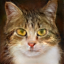

In [7]:
#@title Generate image from the dlatent
dlatent_index =  3#@param {type: "integer"}

expanded_dlatent_tmp = torch.tile(
      torch.unsqueeze(dlatents[dlatent_index], 0),
      [1, num_layers, 1]).to(device)

rec_image = call_synthesis(generator,
    expanded_dlatent_tmp,
    num_layers=num_layers)
image = rec_image[0]
show_image(image)

## Run the Generation step of AttFind
Do not run if loaded from precomputed dlatents.

In [18]:
#@title Generate SSpace per index (min and max) 
values_per_index = collections.defaultdict(list)
for dlatent in dlatents:
  # Get the style vector: 
  dlatent = dlatent.to(device)
  expanded_dlatent_tmp = torch.tile(
      torch.unsqueeze(dlatent, 0),
      [1, num_layers, 1]).to(device)
  generator.eval()
  s_img = torch.cat(generator.get_styles(
      expanded_dlatent_tmp)[0], dim=1)[0].cpu().detach().numpy()
  for i, s_val in enumerate(s_img):
    values_per_index[i].append(s_val)

values_per_index = dict(values_per_index)
s_indices_num = len(values_per_index.keys())
minimums = [min(values_per_index[i]) for i in range(s_indices_num)] 
maximums = [max(values_per_index[i]) for i in range(s_indices_num)] 

In [19]:
torch.cuda.empty_cache()

In [20]:
#@title SSpace calculation (this is also very heavy, skip to next cell to load precomputed ones) {form-width: '20%'}
s_shift_size = 1 # @param
data_path = 'stylegan_stylex_ffhq.tfrecord' #@param {type: 'string'}
batch_size = 10

with tf.io.TFRecordWriter(data_path) as writer:
  for dlatent_index in range(0, dlatents[:40*batch_size].shape[0], batch_size): 
    dlatent = dlatents[dlatent_index:dlatent_index+batch_size].to(device)
    expanded_dlatent = torch.tile(dlatent.unsqueeze(1),
          [1, num_layers, 1])
    base_prob = get_classifier_results(generator, expanded_dlatent, batch_size=batch_size)
    classifier_results = []
    for sindex in tqdm.tqdm(range(0, s_indices_num), leave=False):
      layer_idx, weight_idx = sindex_to_layer_idx_and_index(generator,  sindex)
      layer = generator.style_affines_conv._modules[str(layer_idx)]
      layer_size = layer.modulation.bias.size(0)
      # Get the style vector.
      generator.eval()
      styles = generator.get_styles(expanded_dlatent)
      s_vals = torch.cat(styles[0], dim=1)
      s_shift_down = (minimums[sindex] - s_vals[:,sindex]) * s_shift_size
      s_shift_up = (maximums[sindex] - s_vals[:,sindex]) * s_shift_size
      s_shift_d = s_shift_down.unsqueeze(1) * torch.tile(torch.nn.functional.one_hot(torch.tensor(weight_idx).to(torch.int64).to(device), 
                                                          layer_size).unsqueeze(0), [batch_size, 1])
      with torch.no_grad():
        styles[0][layer_idx] += s_shift_d
        classifier_results.append(
            get_classifier_results(generator,  expanded_dlatent,
                                   input_is_styles=True, styles=styles, batch_size=batch_size) - base_prob)
        styles[0][layer_idx] += -s_shift_d
        s_shift_u = s_shift_up.unsqueeze(1) * torch.tile(torch.nn.functional.one_hot(torch.tensor(weight_idx).to(device).to(torch.int64), 
                                                          layer_size).unsqueeze(0), [batch_size, 1])
        styles[0][layer_idx] += s_shift_u
        classifier_results.append(
            get_classifier_results(generator, expanded_dlatent,
                                   input_is_styles=True, styles=styles, batch_size=batch_size) - base_prob)
        styles[0][layer_idx] += -s_shift_u
    
    for i in range(batch_size):
      feature = {}
      feature['base_prob'] = _float_features(base_prob[i].flatten())
      feature['dlatent'] = _float_features(dlatent[i].flatten().cpu().detach().numpy())
      feature['result'] = _float_features(np.array(classifier_results)[:, i].flatten())
      example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
      writer.write(example_proto.SerializeToString())

## Run the extraction step of AttFind

In [8]:
#@title Load effect data from the tfrecord {form-width: '20%'}
if stylex:
    data_path = f'stylegan_stylex_{dataset}.tfrecord'
else:
    data_path = f'stylegan_normal_{dataset}.tfrecord'
num_classes = 2
print(f'Loaded dataset: {data_path}')
table = tf.data.TFRecordDataset([data_path])
# Read sspace tfrecord unwrapped:
style_change_effect = []
dlatents = []
base_probs = []
max_records = 380
for raw_record in table:
  if max_records == 0:
    break
  max_records -= 1
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  dlatents.append(
      np.array(example.features.feature['dlatent'].float_list.value))
  seffect = np.array(
      example.features.feature['result'].float_list.value).reshape(
          (-1, 2, num_classes))
  style_change_effect.append(seffect.transpose([1, 0, 2]))
  base_probs.append(
      np.array(example.features.feature['base_prob'].float_list.value))

style_change_effect = np.array(style_change_effect)
dlatents = np.array(dlatents)
W_values, style_change_effect, base_probs = dlatents, style_change_effect, np.array(base_probs)


style_change_effect = filter_unstable_images(style_change_effect, effect_threshold=2)

generator.eval()
W_values = torch.Tensor(W_values).to(device)
expanded_W = torch.tile(
          torch.unsqueeze(W_values, 1),
          [1, num_layers, 1])
all_style_vectors = torch.cat(generator.get_styles(
      expanded_W)[0], dim=1).cpu().detach().numpy()
style_min = np.min(all_style_vectors, axis=0)
style_max = np.max(all_style_vectors, axis=0)

all_style_vectors_distances = np.zeros((all_style_vectors.shape[0], all_style_vectors.shape[1], 2))
all_style_vectors_distances[:,:, 0] = all_style_vectors - np.tile(style_min, (all_style_vectors.shape[0], 1))
all_style_vectors_distances[:,:, 1] = np.tile(style_max, (all_style_vectors.shape[0], 1)) - all_style_vectors


Loaded dataset: stylegan_normal_afhq.tfrecord


In [9]:
#@title Split by class

all_labels = np.argmax(base_probs, axis=1)
style_effect_classes = {}
W_classes = {}
style_vectors_distances_classes = {}
all_style_vectors_classes = {}
for img_ind in range(label_size):
  img_inx = np.array([i for i in range(all_labels.shape[0]) 
  if all_labels[i] == img_ind])
  curr_style_effect = np.zeros((len(img_inx), style_change_effect.shape[1], 
                                style_change_effect.shape[2], style_change_effect.shape[3]))
  curr_w = np.zeros((len(img_inx), W_values.shape[1]))
  curr_style_vector_distances = np.zeros((len(img_inx), style_change_effect.shape[2], 2))
  for k, i in enumerate(img_inx):
    curr_style_effect[k, :, :] = style_change_effect[i, :, :, :]
    curr_w[k, :] = W_values[i, :].cpu().detach()
    curr_style_vector_distances[k, :, :] = all_style_vectors_distances[i, :, :]
  style_effect_classes[img_ind] = curr_style_effect
  W_classes[img_ind] = curr_w
  style_vectors_distances_classes[img_ind] = curr_style_vector_distances
  all_style_vectors_classes[img_ind] = all_style_vectors[img_inx]
  print(f'Class {img_ind}, {len(img_inx)} images.')

Class 0, 180 images.
Class 1, 200 images.


In [10]:
#@title Significant S values - combined {form-width: '20%'}
label_size_clasifier = 2 #@param
num_indices =  10 #@param
effect_threshold = 0.5 #@param
use_discriminator = False #@param {type: 'boolean'}
discriminator_model = discriminator if use_discriminator else None
s_indices_and_signs_dict = {}

for class_index in [0, 1]:
  split_ind = 1 - class_index
  all_s = style_effect_classes[split_ind]
  all_w = W_classes[split_ind]

  # Find s indicies
  s_indices_and_signs = find_significant_styles(
    style_change_effect=all_s,
    num_indices=num_indices,
    class_index=class_index,
    discriminator=discriminator_model,
    generator=generator,
    classifier=classifier,
    all_dlatents=all_w,
    style_min=style_min,
    style_max=style_max,
    max_image_effect=effect_threshold*5,
    label_size=label_size_clasifier,
    discriminator_threshold=0.2,
    sindex_offset=0)

  s_indices_and_signs_dict[class_index] = s_indices_and_signs

# Combine the style indicies for the two classes.
sindex_class_0 = [sindex for _, sindex in s_indices_and_signs_dict[0]]

all_sindex_joined_class_0 = [(1 - direction, sindex) for direction, sindex in 
                             s_indices_and_signs_dict[1] if sindex not in sindex_class_0]
all_sindex_joined_class_0 += s_indices_and_signs_dict[0]

scores = []
for direction, sindex in all_sindex_joined_class_0:
  other_direction = 1 if direction == 0 else 0
  curr_score = np.mean(style_change_effect[:, direction, sindex, 0]) + np.mean(style_change_effect[:, other_direction, sindex, 1])
  scores.append(curr_score)

s_indices_and_signs = [all_sindex_joined_class_0[i] for i in np.argsort(scores)[::-1]]

print('Directions and style indices for moving from class 1 to class 0 = ', s_indices_and_signs[:num_indices])
print('Use the other direction to move for class 0 to 1.')

Directions and style indices for moving from class 1 to class 0 =  [(1, 649), (0, 957), (0, 777), (1, 3102), (1, 596), (1, 670), (1, 545), (1, 765), (0, 231), (1, 2193)]
Use the other direction to move for class 0 to 1.


In [11]:
#wu et al.
def find_style_indices_wu(pos_class, all_style_vectors, base_probs):
    pos_styles_list = []
    for i, style in enumerate(all_style_vectors):
        if torch.nn.functional.softmax(torch.tensor(base_probs[i]), dim=0)[pos_class] > .9:
            pos_styles_list.append(style)
    pop_mean = np.mean(all_style_vectors, axis=0)
    pop_std = np.std(all_style_vectors, axis=0)
    differences = [(style-pop_mean)/pop_std for style in pos_styles_list]
    diff_mean = np.mean(differences, axis=0)    
    diff_std = np.std(differences, axis=0)    
    relevance = np.abs(diff_mean)/diff_std
   
    # the method proposed by wu et al. is meant to find important style channels
    # but does not find the direction direction of change
    direction = (diff_mean > 0).astype(int)
    return [(direction[i], i) for i in np.argsort(relevance)][::-1]   

num_indices = 10
pos_class = 0
s_indices_and_signs_wu = find_style_indices_wu(pos_class, all_style_vectors, base_probs)
    
print(f'Directions and style indices for moving from class {int(not pos_class)} to class {pos_class} = ', s_indices_and_signs_wu[:num_indices])
print(f'Directions and style indices for moving from class {pos_class} to class {int(not pos_class)} = ', find_style_indices_wu(int(not pos_class), all_style_vectors, base_probs)[:num_indices])

Directions and style indices for moving from class 1 to class 0 =  [(0, 527), (1, 575), (0, 1923), (1, 697), (1, 699), (0, 93), (1, 765), (0, 617), (1, 368), (1, 507)]
Directions and style indices for moving from class 0 to class 1 =  [(1, 527), (0, 575), (0, 765), (1, 326), (0, 697), (1, 1359), (0, 368), (0, 507), (0, 658), (1, 617)]


In [12]:
num_iterations = 1
num_latents = 1000

flip_rates_attfind = []
flip_rates_wu = []
for i in range(num_iterations):
    if stylex:
        test_latents = generate_latents_encoder(num_latents, loader, classifier, encoder)
    else: 
        test_latents = generate_latents_mapping(num_latents, generator)
    
    expanded_test_latents, test_base_probs, test_style_vectors = process_latents(test_latents, generator, classifier)
    
    test_style_min = np.min(test_style_vectors, axis=0)
    test_style_max = np.max(test_style_vectors, axis=0)
    
    flipped_attfind = find_fliprate(expanded_test_latents,
                  test_base_probs, 
                  s_indices_and_signs,
                  test_style_min,
                  test_style_max,
                  generator,
                  classifier)
    
    flip_rates_attfind.append(len(flipped_attfind)/num_latents)
    
    flipped_wu = find_fliprate(expanded_test_latents,
                  test_base_probs, 
                  s_indices_and_signs_wu,
                  test_style_min,
                  test_style_max,
                  generator,
                  classifier)
    
    flip_rates_wu.append(len(flipped_wu)/num_latents)
    
flip_mean_attfind = np.mean(flip_rates_attfind)
flip_std_attfind = np.std(flip_rates_attfind)
flip_mean_wu = np.mean(flip_rates_wu)
flip_std_wu = np.std(flip_rates_wu)

print(f'mean flip rate attfind: {flip_mean_attfind:.3f} \nstandard deviation: {flip_std_attfind:.3f}\n')
print(f'mean flip rate wu et al: {flip_mean_wu:.3f} \nstandard deviation: {flip_std_attfind:.3f}\n')

mean flip rate attfind: 0.265 
standard deviation: 0.000

mean flip rate wu et al: 0.227 
standard deviation: 0.000



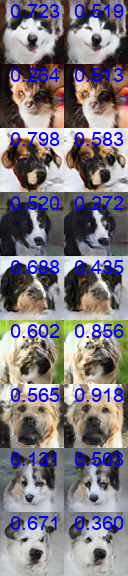

In [13]:
#@title Visualize s-index {form-width: '20%'}

max_images = 50 #@param
sindex =   957#@param
class_index = 0#@param {type: "integer"} 
shift_sign = "1" #@param [0, 1]
wsign_index = int(shift_sign)

shift_size =  1#@param
effect_threshold =  0.2#@param
split_by_class = True #@param {type:"boolean"}
select_images_by_s_distance = False #@param {type:"boolean"}
draw_results_on_image = True #@param {type:"boolean"}

if split_by_class:
  split_ind = 1 if class_index == 0 else 0
  all_s = style_effect_classes[split_ind]
  all_w = W_classes[split_ind]
  all_s_distances = style_vectors_distances_classes[split_ind]
else:
  all_s = style_change_effect
  all_w = W_values
  all_s_distances = all_style_vectors_distances

font_file = 'arialuni.ttf'
if not os.path.exists(font_file):
  r = requests.get('https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/ipwn/arialuni.ttf')
  open(font_file, 'wb').write(r.content)

if not select_images_by_s_distance:
  yy = visualize_style(generator, 
                       classifier,
                       all_w,
                       all_s,
                       style_min,
                       style_max,
                       sindex,
                       wsign_index,
                       max_images=max_images,
                       shift_size=shift_size,
                       font_file=font_file,
                       label_size=label_size,
                       class_index=class_index,
                       effect_threshold=effect_threshold,
                       draw_results_on_image=draw_results_on_image)
    
else:
  yy = visualize_style_by_distance_in_s(
    generator,
    classifier,
    all_w,
    all_s_distances,
    style_min,
    style_max,
    sindex,
    wsign_index,
    max_images=max_images,
    shift_size=shift_size,
    font_file=font_file,
    label_size=label_size,
    class_index=class_index,
    effect_threshold=effect_threshold,
    draw_results_on_image=draw_results_on_image)


if yy.shape != torch.Size([0]):
  show_image(yy)
else:
  print('no images found')

Attribute 0: 
(Original images are on the first row, the probabilities displayed are for the other class)


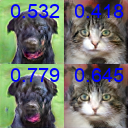

Attribute 1: 
(Original images are on the first row, the probabilities displayed are for the other class)


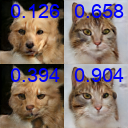

Attribute 2: 
(Original images are on the first row, the probabilities displayed are for the other class)


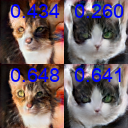

Attribute 3: 
(Original images are on the first row, the probabilities displayed are for the other class)


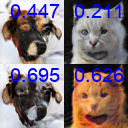

In [14]:
#@title Show the 4 top attributes - as displayed in Fig.4 (b)

draw_probabilities_on_image = True #@param {type: "boolean"}
images_list = [[0, 0], [0, 0], [0, 0], [0, 0]]
max_images = 20
shift_sizes = [(2, 2),(2, 2),(2, 2),(2, 2)]
effect_threshold = 0.2
font_file = 'arialuni.ttf'
if not os.path.exists(font_file):
  gfile.Copy('/google_src/head/depot/google3/googledata/third_party/fonts/ascender/arialuni.ttf', font_file)

for i, (direction, sindex) in enumerate(s_indices_and_signs[:4]):
  images_s = torch.zeros((resolution * 2, resolution * 2, 3))
  for d in [direction, 1 - direction]:
    # Take only images from the offsite class
    class_index = 0 if d == direction else 1
    split_ind = 1 if d == direction else 0
    all_s = style_effect_classes[split_ind]
    all_w = W_classes[split_ind]
    all_s_distances = style_vectors_distances_classes[split_ind]
    # Generate images
    yy = visualize_style_by_distance_in_s(
      generator,
      classifier,
      all_w,
      all_s_distances,
      style_min,
      style_max,
      sindex,
      d,
      max_images=max_images,
      shift_size=shift_sizes[i][class_index],
      font_file=font_file,
      label_size=label_size,
      class_index=class_index,
      effect_threshold=effect_threshold,
      draw_results_on_image=draw_probabilities_on_image)
    
    for n in range(2):
 
      images_s[n * resolution: (n + 1) * resolution, class_index * resolution: (class_index + 1) * resolution, :] = yy[(images_list[i][class_index]) * resolution: (images_list[i][class_index] + 1) * resolution, n * resolution: (n + 1) * resolution, :]
    images_s = images_s.to(torch.int)
  print(f'Attribute {i}: \n(Original images are on the first row, the probabilities displayed are for the other class)')
  show_image(images_s)

